In [379]:
import os
import re
import json
import datetime
import warnings
import polars as pl
import pandas as pd
import altair as alt

from src.najdi_rok import najdi_rok
from src.pocet_stran import pocet_stran
from src.bez_bordelu import bez_bordelu
from src.alt_friendly import alt_friendly
from src.hezke_jmeno import hezke_jmeno
from src.kristi_promin import kristi_promin
from src.zjisti_vazbu import zjisti_vazbu
from src.me_to_neurazi import me_to_neurazi

pl.Config(tbl_rows=100)
alt.data_transformers.disable_max_rows()
alt.themes.register('irozhlas', kristi_promin)
alt.themes.enable('irozhlas')
warnings.filterwarnings('ignore')

with open(os.path.join('src','kredity.json'), 'r', encoding='utf-8') as kredity:
    kredity = json.loads(kredity.read())

## Příprava dat

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [5]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))
len(df)

47994

In [6]:
df = df.merge(pd.read_parquet(os.path.join("data","cnb_vyber.parquet")), left_index=True, right_index=True, how='inner')

In [7]:
len(df)

44343

In [8]:
df = df[df['rok'] >= 2019]

In [9]:
graf_rok_min = int(df['rok'].min())
graf_rok_min

2019

In [10]:
graf_rok_max = int(df['rok'].max())
graf_rok_max

2025

In [11]:
len(df)

8400

In [12]:
df = df.explode('020_a')

In [13]:
def isbn(x):
    try:
        if len(x.replace('-','')) == 13:
            return str(x.replace('-',''))
    except:
        pass

In [14]:
df['isbn'] = df['020_a'].apply(lambda x: isbn(x))

In [15]:
df[['020_a','isbn']].sample(20)

,020_a,isbn
001,,
nkc20223415100,978-80-279-0473-0,9788027904730
nkc20213313412,978-80-270-9933-7,9788027099337
nkc20243662856,978-80-7295-343-1,9788072953431
nkc20203174187,978-80-88039-06-8,9788088039068
nkc20193094816,978-80-88236-04-7,9788088236047
nkc20233533127,978-80-88501-14-5,9788088501145
nkc20243627573,978-80-279-1570-5,9788027915705
nkc20223447329,978-80-86751-63-4,9788086751634
nkc20213368821,978-80-907285-7-8,9788090728578


In [16]:
odkud = "data_raw/ebooky"

In [17]:
stazene = set([x.split(".")[0] for x in os.listdir(odkud)])
len(stazene)

2938

In [18]:
df = df[df['isbn'].isin(stazene)]

In [19]:
df

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20193161777,2019.0,Dobře zašitej frajer,Šabach Petr,jn19990201046,191211s2019 xr g 000 j cze,978-80-7637-070-8,"[Kč 399,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32), (082.21)]",[aut],jn19990201046,"Šabach, Petr,",1951-2017,None,Dobře zašitej frajer /,to nejlepší z Petra Šabacha uspořádali Emil Ha...,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Praze :],"[Paseka,]",[2019],[1],[333 stran ;],None,[23 cm],None,None,"[Údaj o vydání je chybný, správně má být: Vydá...",None,None,None,None,None,None,None,None,None,"[české povídky, české novely, výbory, Czech sh...","[edt, edt]","[jn20000400849, jn19990209335]","[Hakl, Emil,, Kahuda, Václav,]","[1958-, 1965-2023]",None,None,None,None,None,None,None,nam a22 i 4500,9788076370708
nkc20193158828,2019.0,Mstitel z Jenštejna,Vondruška Vlastimil,xx0004129,191111s2019 xr g 000 f cze,978-80-243-8905-9,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.6), (0:82-312.4)]",[aut],xx0004129,"Vondruška, Vlastimil,",1955-,None,Mstitel z Jenštejna /,Vlastimil Vondruška,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2019],[1],[219 stran ;],None,[21 cm],[Letopisy královské komory ;],[XIII],None,None,None,None,None,None,None,None,None,None,"[české romány, historické romány, detektivní r...",None,None,None,None,None,None,None,None,[Letopisy královské komory (MOBA)],None,None,nam a22 i 4500,9788024389059
nkc20243642899,2019.0,Tvůrce osudu,Shy Alice,xx0239405,241113m20199999xr g 000 f cze,978-80-7691-569-5,"[None, Kč 499,00]","[(1 ;, brožováno), (2 ;, brožováno) :]",None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.9)]",[aut],xx0239405,"Shy, Alice,",1990-,None,Tvůrce osudu /,Alice Shy,None,None,None,[1. vydání],None,None,None,None,None,None,None,"[Praha :, V Praze :]","[Ritareklama s.r.o.,, Pointa]","[2019-, None]","[1, 1]",[^^^svazků ;],None,[20 cm],[Knihy Fenix],None,[Od 2. svazku mimo edici],None,None,None,None,None,None,None,None,None,"[české romány, fantasy romány, Czech fiction, ...",None,None,None,None,None,None,None,None,[Knihy Fenix],[Albatros Media - Pointa],None,nam a22 ia4500,9788076915695
nkc20193158538,2019.0,Bezejmenní,Krčmář Milan,jo2012727454,191111s2019 xr h g 000 f cze,978-80-264-2789-6,"[Kč 449,00]","[(CPress ;, vázáno) :]",None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (=411.16), 314.151.3-054.73, 34...",[aut],jo2012727454,"Krčmář, Milan",None,None,Bezejmenní :,Milan Krčmář,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Brně :],"[CPress,]",[2019],[1],[479 stran :],[faksimile ;],[24 cm],None,None,"[V tiráži uvedeno nakladatelství: Edika, Termi...",None,None,"[1921-1930, 20. století, 1925]","[Židé, uprchlíci, vraždy, soudní procesy, Jews...",None,"[20. století, 20. století, 20. století, 1921-1...","[Polsko, Polsko, Česko, Česko, Poland, Poland,...","[Třebíč (Česko), Třebíč (Czechia)]",None,"[české romány, dokumentární romány, fiktivní d...",None,None,None,None,None,None,None,None,None,"[Albatros Media - CPress, Albatros Media - Edika]",None,nam a22 i 4500,9788026427896
nkc20193162052,2019.0,Čarodějnice,Vostrý Mirek,mzk2018995176,200120s2019 xr g 000 j cze,978-80-88318-05-7,None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32)]",[aut],mzk2018995176,"Vostrý, Mirek,",1968-,None,Čarodějnice /,Mirek Vostrý,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brandý

In [20]:
autority = pd.read_parquet(os.path.join("data","aut_vyber.parquet"))

In [21]:
autority = autority.merge(pd.read_parquet(os.path.join('data','wikidata.parquet')), left_index=True, right_index=True, how="outer")

In [22]:
autority.sample(5)

,024_2,024_a_x,046_f,046_g,100_7,100_a,100_d,100_ind1,110_a,370_a,370_b,370_c,370_f,372_a,373_a,374_a,375_a,377_a,400_a,400_d,400_i,400_ind1,410_a,411_a,430_a,450_a,500_a,500_i,500_ind1,550_7,678_a,856_u,leader,024_a_y,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en
mzk2006358011,None,None,None,None,None,None,None,None,None,None,None,[Česko],None,"[historické knihovní fondy, vzácné knihovní fo...",None,None,None,[cze],None,None,None,None,None,None,None,None,None,None,None,None,None,None,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jo20201077113,None,None,[1805],[1865],[jo20201077113],"[Usoz y Río, Luis de,]",[1805-1865],[1],None,None,None,[Španělsko],None,None,None,"[hebraisté, právníci, vysokoškolští učitelé, s...",[muž],"[spa, heb]","[Usoz i Río, Luis de,, Usoz Río, Luis de,, Uso...","[1805-1865, 1805-1865, 1805-1865]",None,"[1, 1, 1]",None,None,None,None,None,None,None,None,"[Španělský hebraista, právník, spisovatel a vy...",None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uk2013758593,None,None,[1869],[1962],[uk2013758593],"[Wissell, Rudolf,]",[1869-1962],[1],None,None,None,[Německo],None,None,None,[politici],[muž],[ger],"[Wissel, Rudolf,]",[1869-1962],None,[1],None,None,None,None,None,None,None,None,"[Německý politik a publicista, autor publikací...",[http://de.wikipedia.org/wiki/Rudolf_Wissell],cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xx0067284,None,None,None,None,[xx0067284],"[Solan, Karel]",None,[1],None,None,None,[Česko],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[Autor detektivky.],None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jo2015883244,None,None,[1906],[1944],[jo2015883244],"[Pražský, V.,]",[1906-asi 1944],[1],None,"[Vápenný Podol, Česko]","[Osvětim, Polsko]",[Česko],None,None,None,"[novináři, spisovatelé]",[muž],[cze],None,None,None,None,None,None,None,None,"[Práger, Vilém,]",[Skutečné jméno:],[1],None,"[Narozen 9. 6. 1906 ve Vápenném Podole, zemřel...",None,nz a22 n 4500,Q95477305,None,None,None,None,[],Vilém Práger,Vilém Práger,None,None,None,"Narozen 9. 6. 1906 ve Vápenném Podole, zemřel ...",None,None,None,"[novinář, redaktor, spisovatel]",None,None,None,None,None,None,None,muž,[Vápenný Podol],[Osvětim],1906.0,+1906-06-09T00:00:00Z,1944.0,+1944-01-01T00:00:00Z,None,None,None


In [23]:
autority.columns

Index(['024_2', '024_a_x', '046_f', '046_g', '100_7', '100_a', '100_d',
       '100_ind1', '110_a', '370_a', '370_b', '370_c', '370_f', '372_a',
       '373_a', '374_a', '375_a', '377_a', '400_a', '400_d', '400_i',
       '400_ind1', '410_a', '411_a', '430_a', '450_a', '500_a', '500_i',
       '500_ind1', '550_7', '678_a', '856_u', 'leader', '024_a_y', 'ceny',
       'druh_umrti', 'facebook', 'instagram', 'jazykove_verze', 'label_cs',
       'label_en', 'manzelstvo', 'obcanstvi', 'partnerstvo', 'popis_cs',
       'popis_en', 'potomstvo', 'pricina_umrti', 'profese', 'role', 'skoly',
       'sourozenectvo', 'strany', 'twitter', 'udalosti', 'vezeni', 'w_gender',
       'w_misto_narozeni', 'w_misto_umrti', 'w_narozeni', 'w_narozeni_presne',
       'w_umrti', 'w_umrti_presne', 'web', 'wiki_cs', 'wiki_en'],
      dtype='object')

In [24]:
df = df.merge(autority[['w_gender','w_umrti','046_g','375_a']], left_on="autorstvo_kod", right_index=True, how="left")

In [25]:
df = df[(df['w_umrti'].isnull()) | (df['046_g'].isnull())]

In [26]:
df.sample(5)

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn,w_gender,w_umrti,046_g,375_a
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20243600446,2024.0,Nejasné hranice,Domská Marie,xx0216223,240409s2024 xr g 000 f cze,978-80-275-2013-8,None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.9)]",[aut],xx0216223,"Domská, Marie,",1982-,None,Nejasné hranice :,Marie Domská,None,None,None,[První vydání],None,None,None,None,None,None,None,[Brno :],"[Host,]",[2024],[1],[453 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, vědecko-fantastické romány, Cze...",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788027520138,žena,NaN,None,[žena]
nkc20233567393,2023.0,Dlouhý most,Pelíšek Antonín,xx0015543,231122s2023 xr a g 000 j cze,978-80-264-5055-9,"[Kč 299,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32)]",[aut],xx0015543,"Pelíšek, Antonín,",1952-,None,Dlouhý most /,Antonín Pelíšek,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Brně :],"[CPress,]",[2023],[1],[142 stran :],[ilustrace ;],[22 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české novely, Czech novellas]",None,None,None,None,None,None,None,None,None,[Albatros Media - CPress],None,nam a22 i 4500,9788026450559,muž,NaN,None,None
nkc20213375952,2021.0,Kadanland,Dvořák Stanislav,xx0151297,211123s2021 xr g 000 f cze,978-80-279-0053-4,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],xx0151297,"Dvořák, Stanislav",None,None,Kadanland /,Stanislav Dvořák,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2021],[1],[211 stran ;],None,[19 cm],"[Původní česká detektivka ;, Krimi]","[351. svazek, None]",None,None,[Český text],None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788027900534,None,NaN,None,None
nkc20243603771,2024.0,Svátek hada,Hlavinková Lucie,xx0212699,240503s2024 xr g 000 f cze,978-80-267-2643-2,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.6)]",[aut],xx0212699,"Hlavinková, Lucie,",1974-,None,Svátek hada /,Lucie Hlavinková,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Praze :],"[Motto,]",[2024],[1],[224 stran ;],None,[22 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, historické romány, Czech fictio...",None,None,None,None,None,None,None,None,None,[Albatros Media - Motto],None,nam a22 i 4500,9788026726432,žena,NaN,None,[žena]
nkc20243624377,2024.0,Královna Viola,Denková Melita,jn20020716688,240726s2024 xr g 000 fbcze,978-80-7695-192-1,None,[(vázáno)],None,None,None,None,"[821.162.3-3, 929]","[Česká próza, Biografie]","[821.162.3-31, 929.731-055.2, 929.731-058.833,...",[aut],jn20020716688,"Denková, Melita,",1951-,None,Královna Viola :,Melita Denková,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Frýdek-Místek :],"[Alpress,]",[2024],[1],[232 stran ;],None,[21 cm],[Klokan],None,None,None,None,"[14. století, 1290-1317]","[panovnice, manželky panovníků, queens and emp...",None,"[14. století, 14. století, 14th century, 14th ...","[Česko, Česko, Czechia, Czechia]",None,None,"[české romány, historické romány, Czech fictio...",None,None,None,None,None,None,None,None,[Klokan (Alpress)],None,None,nam a22 i 4500,9788076951921,žena,NaN,None,None


In [27]:
len(df)

1328

In [28]:
len(df[df['w_gender'].notnull()])

1279

In [29]:
def tri_gendery(trisedmpeta, gender_wikidata, autors):
    z = None
    if (str(autors).split(" ")[0][-1] == 'á'):
        z = 'á'
    else:
        z = 'neá'
    if gender_wikidata in (['muž','žena']):
        z = gender_wikidata
    try:
        for y in trisedmpeta:
            z = y
    except:
        pass
    return z

In [30]:
df['gender'] = df.apply(lambda row: tri_gendery(row['375_a'],row['w_gender'],row['autorstvo']), axis=1)

In [31]:
df[['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,
nkc20193158828,Vondruška Vlastimil,muž,[muž],muž
nkc20243642899,Shy Alice,žena,[žena],žena
nkc20193158538,Krčmář Milan,muž,None,muž
nkc20193162052,Vostrý Mirek,muž,[muž],muž
nkc20193162055,Rollingerová-Riba Romana,žena,None,žena
...,...,...,...,...
nkc20243607607,Kořínek Václav,muž,[muž],muž
nkc20243607374,Kostka Karel,muž,None,muž
nkc20243607405,Neff Ondřej,muž,None,muž


In [32]:
df[df['gender'].isnull()][['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,


## Příprava knih

In [34]:
import simplemma

In [35]:
def remove_non_letters(input_string):
        # Define an empty string to store our result
        result_string = ''

        # Loop through each character in the given string
        for character in input_string:
            # If the character is a letter or whitespace
            if character.isalpha() or character.isspace():
                # Include it in our result string
                result_string += character

        # Return the cleaned string
        return result_string

In [36]:
ukazky = []
for i in df[df['gender'].notnull()]['isbn'].to_list():
    ukazka = {}
    ukazka['isbn'] = i
    with open(os.path.join(odkud, f"{i}.txt"), 'r', encoding='utf-8') as u:
        text = remove_non_letters(u.read().lower().strip().replace('\n',' ').replace('\t','').replace('\xa0',' '))
        slova = []
        ukazka['rozsah'] = len(text)
        for t in [t for t in text.split(' ') if len(t) > 2]:
            slova.append(simplemma.lemmatize(t, lang='cs'))
        ukazka['slova'] = set(slova)
        if len(set(slova)) > 50:
            ukazky.append(ukazka)

In [37]:
mz = pd.DataFrame(ukazky)
mz.sample(5)

,isbn,rozsah,slova
827,9788027711208,62214,"{nebuď, pověřený, naléhala, podstatně, duch, z..."
502,9788076503908,15173,"{zavést, sbalit, džíny, duch, chodník, landmar..."
446,9788076503199,46660,"{meč, duch, klídek, zaslechnout, jakýsi, roztá..."
718,9788027510481,13158,"{jaký, perský, uvrhl, svině, voják, zdát, cari..."
496,9788075882912,33774,"{dovolená, pěstit, podstatně, duch, padákového..."


In [38]:
mz = mz.merge(df[['isbn','gender','autorstvo_kod']], left_on='isbn', right_on='isbn', how='left')

In [39]:
mz

,isbn,rozsah,slova,gender,autorstvo_kod
0,9788024389059,20745,"{podstatně, znával, zaslechnout, supěl, jakýsi...",muž,xx0004129
1,9788026427896,110563,"{potrestat, Evropa, hůl, duch, mojše, jakýsi, ...",muž,jo2012727454
2,9788088318057,18416,"{jaký, usmyslel, zaslechnout, nebožtík, pronés...",muž,mzk2018995176
3,9788074872792,20802,"{pěšák, splývající, iks, kompromitovaná, rozjí...",žena,jo20000075610
4,9788024389141,16962,"{potrestat, povalujíst, vzbudit, vydělat, brno...",muž,xx0122614
...,...,...,...,...,...
1293,9788027742691,12455,"{hrdina, rozchechtalo, úvod, lampičku, slinivk...",muž,xx0189200
1294,9788076951822,33056,"{rozkoš, duch, intimnosti, důležitý, mytologic...",muž,jo2006362253
1295,9788075886170,16377,"{zakázaný, jištěné, jaký, čucháka, skutečný, k...",muž,jk01082907
1296,9788027152902,16589,"{popadal, vydělat, postup, jaký, usmyslel, roz...",muž,jn20010712010


## Základní statistiky (mužská slova >1, ženská slova <1)

In [41]:
len(mz[mz['gender'] == 'muž'])

588

In [42]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()

359

In [43]:
len(mz[mz['gender'] == 'žena'])

676

In [44]:
mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

427

In [45]:
mz = mz.drop_duplicates(subset=['autorstvo_kod'], keep="last")

Rozsah zkoumaného textu v NS:

In [47]:
mz['rozsah'].sum() / 1800

12595.685555555556

In [48]:
graf_rozsah = int((mz['rozsah'].sum() / 1800 / 1000).round())
graf_rozsah

13

In [49]:
graf_muzi = mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()
graf_muzi

359

In [50]:
graf_zeny = mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()
graf_zeny

427

Velikost vzorku celkem:

In [52]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique() +mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

786

In [53]:
mz_slova = mz.explode('slova')

In [54]:
kolik = mz_slova.groupby("slova").size()

In [55]:
kolik.quantile([0.01, 0.02, 0.1, 0.5, 0.75, 0.9, 0.99, 0.999])

0.010      1.000
0.020      1.000
0.100      1.000
0.500      1.000
0.750      3.000
0.900     10.000
0.990    152.000
0.999    620.743
dtype: float64

In [56]:
kolik

slova
Abraham      4
Abrahám      4
Achilles     1
Adam        62
Adamec       2
            ..
שקרן         1
 září        1
  pátek      1
 který       1
 patro       1
Length: 154258, dtype: int64

In [57]:
hrana = int(kolik.quantile(0.97))
hrana

48

In [58]:
mz_vyfiltrovana = kolik[kolik >= 5].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(20))
print(pomer.sort_values().tail(20))

slova
protočila      0.059471
sedávat        0.066079
převalovala    0.079294
drdol          0.079294
nebolelo       0.084958
zamumlá        0.084958
nezeptala      0.084958
vdát           0.084958
stesk          0.084958
Gabriel        0.084958
cpala          0.084958
zarytě         0.091493
dojíždět       0.091493
otrávená       0.091493
poskládaný     0.091493
mělas          0.091493
sáru           0.091493
hřebínek       0.091493
vstávala       0.091493
zasměju        0.091493
dtype: float64
slova
long            11.894150
dějový          11.894150
Budějovice      11.894150
odtržený        11.894150
ručit           13.083565
vpravdě         13.083565
nábojnice       13.083565
eknihu          13.083565
vyučoval        13.083565
zavedený        13.083565
Chicago         13.083565
lepidlo         13.083565
útočný          13.083565
formátů         14.272981
exil            14.272981
kolmo           14.272981
rozvinutý       15.462396
komerční        15.462396
boxer           16.651811

In [59]:
mz_vyfiltrovana = kolik[kolik >= 10].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(20))
print(pomer.sort_values().tail(20))
pomer.sort_values().to_csv("data/muzska_zenska_slova_10+.csv")

slova
protočila      0.059471
sedávat        0.066079
převalovala    0.079294
drdol          0.079294
nebolelo       0.084958
stesk          0.084958
cpala          0.084958
nezeptala      0.084958
Gabriel        0.084958
zamumlá        0.084958
vdát           0.084958
zasměju        0.091493
sáru           0.091493
otrávená       0.091493
dojíždět       0.091493
zarytě         0.091493
mělas          0.091493
poskládaný     0.091493
vstávala       0.091493
hřebínek       0.091493
dtype: float64
slova
ráže            11.894150
wwwargocz       11.894150
schválený       11.894150
chebu           11.894150
eknihu          13.083565
útočný          13.083565
lepidlo         13.083565
vpravdě         13.083565
vyučoval        13.083565
nábojnice       13.083565
zavedený        13.083565
Chicago         13.083565
ručit           13.083565
formátů         14.272981
exil            14.272981
kolmo           14.272981
rozvinutý       15.462396
komerční        15.462396
boxer           16.651811

In [60]:
mz_vyfiltrovana = kolik[kolik >= 20].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(40))
print(pomer.sort_values().tail(40))
pomer.sort_values().to_csv("data/muzska_zenska_slova_20+.csv")

slova
protočila      0.059471
pleso          0.099118
kosmetička     0.108129
nebála         0.113278
díkybohu       0.125202
rtěnku         0.132157
kadeřník       0.148677
okřikla        0.162193
vykulila       0.169916
myčka          0.176210
odfrkla        0.176210
zalíbený       0.178412
převléct       0.178412
zabouchla      0.182987
babi           0.185020
snila          0.185846
odhodlaná      0.187802
nedivila       0.187802
ptají          0.198236
zvala          0.198236
zrudnout       0.205072
natahuje       0.206855
nakloní        0.212396
netušila       0.222198
mateřství      0.223015
opáčila        0.223015
zamrkala       0.225024
rtěnkou        0.226555
ležérně        0.226555
zajela         0.226555
ječela         0.226555
stýská         0.226555
výstřihu       0.226555
pozdravovat    0.226555
culík          0.230209
nesměla        0.231275
ramínko        0.232081
vyzvídat       0.237883
odhrnula       0.237883
uvolněně       0.237883
dtype: float64
slova
norma        

In [61]:
mz_vyfiltrovana = kolik[kolik >= 100].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(20))
print(pomer.sort_values().tail(20))
pomer.sort_values().to_csv("data/muzska_zenska_slova_100+.csv")

slova
netušila      0.222198
kamarádka     0.334523
ptala         0.345314
četla         0.388847
sukně         0.411721
brečet        0.466437
neřekla       0.487660
manželství    0.506385
růžový        0.506964
hrnek         0.509749
vyhovovat     0.517137
kabelka       0.518787
zvědavě       0.525196
hladit        0.528629
naštvaný      0.528629
kavárna       0.530065
trapný        0.533186
mléko         0.534569
klín          0.540643
vařit         0.542743
dtype: float64
slova
kostel       1.784123
obsahovat    1.811155
vedení       1.811155
stavba       1.829869
dílo         1.843593
údolí        1.846723
autor        1.873329
národní      1.885658
nepřítel     1.893355
moce         1.932799
úder         1.962535
dějiny       1.982358
výkon        2.003225
vojenský     2.102222
armáda       2.104350
loď          2.218098
Evropa       2.226990
státní       2.310864
vražda       2.317834
motor        2.378830
dtype: float64


In [62]:
mz_vyfiltrovana = kolik[kolik >= 50].index.to_list()
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()
pomer = m / z
print(pomer.sort_values().head(40))
print(pomer.sort_values().tail(40))
pomer.sort_values().to_csv("data/muzska_zenska_slova_50+.csv")

slova
babi           0.185020
netušila       0.222198
zahlédla       0.243983
užívala        0.278374
pyžamo         0.278374
nečekala       0.278769
lekla          0.283194
salát          0.297354
neuměla        0.303184
rozhlížela     0.319111
ucítila        0.322841
kamarádka      0.334523
ptala          0.345314
miminko        0.348121
nestihla       0.354294
obývací        0.374445
objímat        0.374747
přejela        0.376648
rande          0.381510
zadívala       0.383682
vyhrkla        0.387853
četla          0.388847
chystala       0.396472
ordinace       0.396472
nešla          0.396472
příšerně       0.404907
povytáhnout    0.406905
sukně          0.411721
ušklíbla       0.419794
mamka          0.422903
svačina        0.424791
čokoláda       0.428969
zamilovaný     0.430947
milá           0.432515
nalila         0.435152
taneční        0.436928
namalovat      0.436928
zasyčet        0.436928
sexy           0.439566
chytla         0.439566
dtype: float64
slova
poctivý      

## Všechna slova bez filtru

In [64]:
z2 = mz[mz['gender'] == 'žena'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m2 = mz[mz['gender'] == 'muž'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [65]:
pomer_vsech = m2 / z2

In [66]:
pomer_vsech.dropna().sort_values().head(20)

slova
protočila      0.059471
sedávat        0.066079
drdol          0.079294
převalovala    0.079294
Gabriel        0.084958
nebolelo       0.084958
nezeptala      0.084958
zamumlá        0.084958
cpala          0.084958
stesk          0.084958
otrávená       0.091493
hřebínek       0.091493
mělas          0.091493
dojíždět       0.091493
zasměju        0.091493
poskládaný     0.091493
vstávala       0.091493
uvázala        0.099118
uchechtne      0.099118
randění        0.099118
dtype: float64

In [67]:
pomer_vsech[pomer_vsech.index == 'erekce']

slova
erekce    9.51532
dtype: float64

In [68]:
pomer_vsech[pomer_vsech.index == 'orgasmus']

slova
orgasmus    0.892061
dtype: float64

In [69]:
pomer_vsech[pomer_vsech.index == 'pohlazení']

slova
pohlazení    0.548961
dtype: float64

In [70]:
pomer_vsech[pomer_vsech.index == 'svázat']

slova
svázat    0.618496
dtype: float64

In [71]:
pomer_vsech[pomer_vsech.index == 'výprask']

slova
výprask    1.189415
dtype: float64

In [72]:
pomer_vsech[pomer_vsech.index == 'naplácat']

slova
naplácat    2.973538
dtype: float64

In [73]:
pomer_vsech[pomer_vsech.index == 'hnědooký']

slova
hnědooký    1.784123
dtype: float64

In [74]:
pomer_vsech[pomer_vsech.index == 'modrooký']

slova
modrooký    0.743384
dtype: float64

In [75]:
pomer_vsech[pomer_vsech.index == 'plešatý']

slova
plešatý    0.634355
dtype: float64

In [76]:
pomer_vsech[pomer_vsech.index == 'holohlavý']

slova
holohlavý    3.568245
dtype: float64

In [77]:
pomer_vsech[pomer_vsech.index == 'sex']

slova
sex    0.909553
dtype: float64

In [78]:
pomer_vsech[pomer_vsech.index == 'fiat']

slova
fiat    2.37883
dtype: float64

In [79]:
pomer_vsech[pomer_vsech.index == 'kunda']

slova
kunda    2.37883
dtype: float64

In [80]:
pomer_vsech[pomer_vsech.index == 'prdel']

slova
prdel    1.297544
dtype: float64

In [81]:
pomer_vsech[pomer_vsech.index == 'hovno']

slova
hovno    1.158115
dtype: float64

In [82]:
pomer_vsech[pomer_vsech.index == 'čurák']

slova
čurák    2.973538
dtype: float64

In [83]:
pomer_vsech[pomer_vsech.index == 'čůrák']

Series([], dtype: float64)

In [84]:
pomer_vsech[pomer_vsech.index == 'svině']

slova
svině    7.13649
dtype: float64

In [85]:
pomer_vsech[pomer_vsech.index == 'hajzl']

slova
hajzl    1.229062
dtype: float64

In [86]:
pomer_vsech[pomer_vsech.index == 'šmejd']

slova
šmejd    4.460306
dtype: float64

In [87]:
pomer_vsech[pomer_vsech.index == 'potvora']

slova
potvora    0.699656
dtype: float64

In [88]:
pomer_vsech[pomer_vsech.index == 'píča']

slova
píča    1.665181
dtype: float64

In [89]:
pomer_vsech[pomer_vsech.index == 'piča']

slova
piča    0.892061
dtype: float64

In [90]:
pomer_vsech[pomer_vsech.index == 'lojza']

slova
lojza   NaN
dtype: float64

In [91]:
pomer_vsech[pomer_vsech.index == 'káča']

slova
káča    0.594708
dtype: float64

In [92]:
pomer_vsech[pomer_vsech.index == 'blbec']

slova
blbec    0.853276
dtype: float64

In [93]:
pomer_vsech[pomer_vsech.index == 'magor']

slova
magor    1.189415
dtype: float64

In [94]:
pomer_vsech[pomer_vsech.index == 'cápek']

slova
cápek   NaN
dtype: float64

In [95]:
pomer_vsech[pomer_vsech.index == 'kráva']

slova
kráva    0.853939
dtype: float64

In [96]:
pomer_vsech[pomer_vsech.index == 'bastard']

slova
bastard    1.903064
dtype: float64

In [97]:
pomer_vsech[pomer_vsech.index == 'blázen']

slova
blázen    0.945015
dtype: float64

In [98]:
pomer_vsech[pomer_vsech.index == 'bestie']

slova
bestie    2.907459
dtype: float64

In [99]:
pomer_vsech[pomer_vsech.index == 'husa']

slova
husa    0.713649
dtype: float64

In [100]:
pomer_vsech[pomer_vsech.index == 'porno']

slova
porno    2.888579
dtype: float64

In [101]:
pomer_vsech[pomer_vsech.index == 'vagína']

slova
vagína    1.784123
dtype: float64

In [102]:
pomer_vsech[pomer_vsech.index == 'penis']

slova
penis    0.991179
dtype: float64

In [103]:
pomer_vsech[pomer_vsech.index == 'močit']

slova
močit    4.361188
dtype: float64

In [104]:
pomer_vsech[pomer_vsech.index == 'čůrat']

slova
čůrat    0.792943
dtype: float64

In [105]:
pomer_vsech[pomer_vsech.index == 'čurat']

slova
čurat    0.991179
dtype: float64

In [106]:
pomer_vsech[pomer_vsech.index == 'fousy']

slova
fousy    1.784123
dtype: float64

In [107]:
pomer_vsech[pomer_vsech.index == 'chlup']

slova
chlup    0.619487
dtype: float64

In [108]:
pomer_vsech[pomer_vsech.index == 'nádor']

slova
nádor    1.585887
dtype: float64

In [109]:
pomer_vsech[pomer_vsech.index == 'fotbal']

slova
fotbal    1.640572
dtype: float64

In [110]:
pomer_vsech[pomer_vsech.index == 'hokej']

slova
hokej    1.784123
dtype: float64

In [111]:
pomer_vsech[pomer_vsech.index == 'rallye']

slova
rallye    1.189415
dtype: float64

In [112]:
pomer_vsech[pomer_vsech.index == 'Krkonoše']

slova
Krkonoše    0.925101
dtype: float64

In [113]:
pomer_vsech[pomer_vsech.index == 'Šumava']

slova
Šumava    1.453729
dtype: float64

In [114]:
pomer_vsech[pomer_vsech.index == 'Říp']

slova
Říp    1.189415
dtype: float64

In [115]:
pomer_vsech[pomer_vsech.index == 'hymna']

slova
hymna    1.982358
dtype: float64

In [116]:
pomer_vsech[pomer_vsech.index == 'svačina']

slova
svačina    0.424791
dtype: float64

In [117]:
pomer_vsech[pomer_vsech.index == 'budík']

slova
budík    0.746842
dtype: float64

In [118]:
pomer_vsech[pomer_vsech.index == 'nakřivo']

slova
nakřivo    0.849582
dtype: float64

In [119]:
pomer_vsech[pomer_vsech.index == 'šikmo']

slova
šikmo    2.973538
dtype: float64

In [120]:
pomer_vsech[pomer_vsech.index == 'víno']

slova
víno    0.754263
dtype: float64

In [121]:
pomer_vsech[pomer_vsech.index == 'pivo']

slova
pivo    1.25346
dtype: float64

In [122]:
pomer_vsech[pomer_vsech.index == 'slivovice']

slova
slivovice    0.237883
dtype: float64

In [123]:
pomer_vsech[pomer_vsech.index == 'Havel']

slova
Havel    1.486769
dtype: float64

In [124]:
pomer_vsech[pomer_vsech.index == 'Masaryk']

slova
Masaryk    3.270891
dtype: float64

In [125]:
pomer_vsech[pomer_vsech.index == 'Hitler']

slova
Hitler    2.718663
dtype: float64

In [126]:
pomer_vsech[pomer_vsech.index == 'poker']

slova
poker    1.189415
dtype: float64

In [127]:
pomer_vsech[pomer_vsech.index == 'alkohol']

slova
alkohol    0.91227
dtype: float64

In [128]:
pomer_vsech[pomer_vsech.index == 'líh']

slova
líh    2.37883
dtype: float64

In [129]:
pomer_vsech[pomer_vsech.index == 'kořalka']

slova
kořalka    1.513801
dtype: float64

In [130]:
pomer_vsech[pomer_vsech.index == 'znásilnit']

slova
znásilnit    0.528629
dtype: float64

In [131]:
pomer_vsech[pomer_vsech.index == 'zadek']

slova
zadek    0.805142
dtype: float64

In [132]:
pomer_vsech[pomer_vsech.index == 'větrník']

slova
větrník    2.37883
dtype: float64

In [133]:
pomer_vsech[pomer_vsech.index == 'kafíčko']

slova
kafíčko    0.396472
dtype: float64

In [134]:
pomer_vsech[pomer_vsech.index == 'dítě']

slova
dítě    0.908727
dtype: float64

In [135]:
pomer_vsech[pomer_vsech.index == 'doutník']

slova
doutník    1.982358
dtype: float64

In [136]:
pomer_vsech[pomer_vsech.index == 'cigareta']

slova
cigareta    1.226976
dtype: float64

In [137]:
pomer_vsech[pomer_vsech.index == 'babička']

slova
babička    0.581036
dtype: float64

In [138]:
pomer_vsech[pomer_vsech.index == 'dědeček']

slova
dědeček    0.876411
dtype: float64

In [139]:
pomer_vsech[pomer_vsech.index == 'blbec']

slova
blbec    0.853276
dtype: float64

In [140]:
pomer_vsech[pomer_vsech.index == 'blbka']

slova
blbka    0.669046
dtype: float64

In [141]:
pomer_vsech[pomer_vsech.index == 'Praha']

slova
Praha    1.205935
dtype: float64

In [142]:
pomer_vsech[pomer_vsech.index == 'Brno']

slova
Brno    0.907711
dtype: float64

In [143]:
pomer_vsech[pomer_vsech.index == 'Olomouc']

slova
Olomouc    2.973538
dtype: float64

In [144]:
pomer_vsech[pomer_vsech.index == 'Ostrava']

slova
Ostrava    0.872238
dtype: float64

In [145]:
pomer_vsech[pomer_vsech.index == 'Jablonec']

slova
Jablonec    0.594708
dtype: float64

In [146]:
pomer_vsech[pomer_vsech.index == 'Tatry']

slova
Tatry    1.189415
dtype: float64

In [147]:
pomer_vsech[pomer_vsech.index == 'kombajn']

slova
kombajn   NaN
dtype: float64

In [148]:
pomer_vsech[pomer_vsech.index == 'koňak']

slova
koňak    0.792943
dtype: float64

In [149]:
pomer_vsech[pomer_vsech.index == 'whisky']

slova
whisky    1.126814
dtype: float64

In [150]:
pomer_vsech[pomer_vsech.index == 'rum']

slova
rum    1.263753
dtype: float64

In [151]:
pomer_vsech[pomer_vsech.index == 'toust']

slova
toust    0.108129
dtype: float64

In [152]:
pomer_vsech[pomer_vsech.index == 'topinka']

slova
topinka    1.189415
dtype: float64

In [153]:
pomer_vsech[pomer_vsech.index == 'rýže']

slova
rýže    0.939012
dtype: float64

## Celkový pohled

In [155]:
muzi = mz_filtr[mz_filtr['gender'] == 'muž']['autorstvo_kod'].to_list()
', '.join(sorted((df[df['autorstvo_kod'].isin(muzi)]['autorstvo'].drop_duplicates().to_list())))

'Addair Theo, Ajvaz Michal, Balda David, Balák Libor, Banga Patrik, Bareš Pavel, Bauer Jan, Bazger Petr, Beran Ladislav, Beran Stanislav, Bernatský Vojtěch, Bečan Martin, Birdman Shigor, Blaho Ondřej, Boubín Dalibor, Boček Evžen, Boček Lukáš, Brož Petr, Budai David, Buddeus Ondřej, Bureš Roman, Bálek Jaroslav, Bárta Václav, Bílek Petr, Bým Petr, Březina Jiří, Březina Michal, Chadima Martin, Csicsely Lukáš, Ctibor Pavel, Cubeca Karel, Cílek Roman, Dadák Matěj, Decimus Erik, Denk Petr, Ditrych Břetislav, Diviš Aleš, Dobrylovský Jiří, Dobrý Marek, Dostál Aleš, Dotlačil Jakub, Doucha Josef, Dočekal Boris, Drbohlav Jan, Drescher Alex, Duda Jan, Dutka Edgar, Dvořák Marek, Dědič Jiří, Eidler Petr, Epstein Marek, Erml Richard, Fahrner Martin, Fanta Ondřej, Fibich Ondřej, Fišer Lukáš, Fišer Martin, Folný Jan, Fousek Josef, Fránek Jakub, Fuchs Oskar, Fíla Ivan, Galambica Ivan, Gardner Jan, Gdovín Vladimír Adam, Glockner David, Goffa Martin, Grant Jiří, Gravensteen A., Green Scum, Gris Daniel, Gr

In [156]:
zeny = mz_filtr[mz_filtr['gender'] == 'žena']['autorstvo_kod'].drop_duplicates().to_list()
', '.join(sorted(df[df['autorstvo_kod'].isin(zeny)]['autorstvo'].drop_duplicates().to_list()))

'Abrahámová Martina, Addicks Lucie, Ambrožová Dorota, An Elen, Andrlová Šárka, Auzká Lucie, Aycox Klára, Babišová Martina, Bartošová Tereza, Basiková Anna, Basiková Bára, Baštanová Petra, Bechynková Lucie, Bellová Bianca, Bendová Karolína, Beranová Dana, Bernášková Jana, Blahová Miriam, Blanářová Alena, Blažková Kateřina, Bohatá Simona, Boho Michaela, Bolavá Anna, Bolfová Markéta, Borlová Julie, Boučková Martina, Boučková Tereza, Brabcová Kateřina, Braunová Petra, Brányiková Katarína, Bublanová Alžběta, Burgerová Kristýna, Bártová Anna Beatrix, Bílková Alžběta, Cajthamlová Kateřina, Camille G, Chalupníková Kateřina, Chalupová Lenka, Chaya Lucie, Chlubnová Lenka, Cima Anna, Ciprová Oldřiška, Coufalová Valentýna, Czastková Klára, Damijo Alena, Dancingerová Marta, Denemarková Radka, Denková Melita, Devátá Ivanka, Divišová Anna, Dobiášová Tereza, Dobrovolná Ilona, Dolejšová Eva, Domská Marie, Donátová Uljana, Dopitová Michaela, Dostálová Zuzana, Dousková Irena, Dočkalová Tereza, Drdlová He

In [157]:
len(pomer)

4548

<Axes: ylabel='Frequency'>

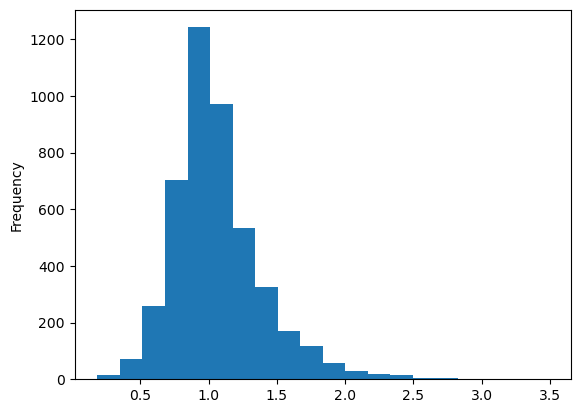

In [158]:
pomer.plot.hist(bins=20)

In [159]:
neutralita = pd.DataFrame(pomer).rename(columns={0:'cetnost'})
neutralita['odchylka'] = neutralita['cetnost'].apply(lambda x: x-1 if x>1 else 1-x)
neutralita.sort_values(by='odchylka').head(60)

,cetnost,odchylka
slova,,
jako,1.000000,0.000000
když,1.000000,0.000000
být,1.000000,0.000000
ale,1.000000,0.000000
vnitřní,0.999951,0.000049
možný,1.000190,0.000190
svátek,1.000190,0.000190
vzpomenout,0.999798,0.000202
chytrý,0.999615,0.000385


## Slova více používaná muži-spisovateli

In [161]:
pomer.sort_values(ascending=False).head(25)

slova
pistole          3.488951
prezident        3.218417
ruský            3.067439
souboj           2.907459
kladivo          2.854596
kulka            2.775302
vůl              2.750522
velet            2.696007
služebný         2.691834
politik          2.676184
střílet          2.662024
zaregistrovat    2.601845
nepříliš         2.577066
civilizace       2.541023
zvláště          2.510987
zápas            2.510987
posléze          2.497772
hlídka           2.497772
západní          2.466935
komín            2.444909
ohrozit          2.444909
riziko           2.438301
vývoj            2.435469
lebka            2.430544
technický        2.428389
dtype: float64

In [162]:
pomer[pomer.index.str.endswith('la')].sort_values()

slova
netušila      0.222198
zahlédla      0.243983
užívala       0.278374
nečekala      0.278769
lekla         0.283194
neuměla       0.303184
rozhlížela    0.319111
ucítila       0.322841
ptala         0.345314
nestihla      0.354294
přejela       0.376648
zadívala      0.383682
vyhrkla       0.387853
četla         0.388847
nešla         0.396472
chystala      0.396472
ušklíbla      0.419794
nalila        0.435152
chytla        0.439566
nechávala     0.442573
odložila      0.470810
strčila       0.470810
usmívala      0.471665
neřekla       0.487660
sklopila      0.487965
zamávala      0.495590
vzdychla      0.509749
zasmála       0.548961
mávla         0.548961
vyrazila      0.552827
odvětila      0.558297
odsekla       0.594708
zažila        0.610781
nepřišla      0.636199
přikývla      0.660786
jezdila       0.725253
pohladila     0.735275
dokola        0.799779
Hela          0.849582
stodola       0.861301
škola         0.888590
jehla         0.911885
smůla         0.984343
docel

## Slova více používaná ženami-spisovatelkami

Pleso vypadá spíš jako špatné lemma slova ples.

In [165]:
(1 / pomer).sort_values(ascending=False).head(25)

slova
babi          5.404818
netušila      4.500482
zahlédla      4.098653
užívala       3.592293
pyžamo        3.592293
nečekala      3.587198
lekla         3.531148
salát         3.362998
neuměla       3.298325
rozhlížela    3.133702
ucítila       3.097498
kamarádka     2.989331
ptala         2.895915
miminko       2.872560
nestihla      2.822516
obývací       2.670616
objímat       2.668466
přejela       2.654998
rande         2.621160
zadívala      2.606323
vyhrkla       2.578298
četla         2.571704
ordinace      2.522248
chystala      2.522248
nešla         2.522248
dtype: float64

## Graf

In [167]:
pomer_vsech.sample(20)

slova
redakce          1.627621
zanalyzoval           NaN
poryvu           0.396472
pohřbívání            NaN
ventilový             NaN
dosledu               NaN
uslzeného             NaN
litosférickou         NaN
komplicové            NaN
patlají               NaN
nevyčuhovat      1.189415
cifru                 NaN
gruiwové              NaN
sběrném          1.784123
problémovej      1.189415
výsadba          2.378830
hloubavé              NaN
neumělý               NaN
křupal                NaN
tajuplně         1.585887
dtype: float64

In [168]:
pomer.reset_index()

,slova,0
0,Adam,0.979518
1,Amerika,1.331012
2,Anglie,1.101310
3,Anna,1.054254
4,Brno,0.907711
...,...,...
4543,žádost,1.477758
4544,žák,1.369629
4545,žíla,1.361083
4546,žít,0.884925


In [169]:
import polars as pl

In [170]:
pomer

slova
Adam       0.979518
Amerika    1.331012
Anglie     1.101310
Anna       1.054254
Brno       0.907711
             ...   
žádost     1.477758
žák        1.369629
žíla       1.361083
žít        0.884925
žízeň      1.379721
Length: 4548, dtype: float64

In [171]:
pomer = pomer.reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})

In [172]:
pomer

,slovo,rozdíl
0,Adam,0.979518
1,Amerika,1.331012
2,Anglie,1.101310
3,Anna,1.054254
4,Brno,0.907711
...,...,...
4543,žádost,1.477758
4544,žák,1.369629
4545,žíla,1.361083
4546,žít,0.884925


In [173]:
pomer_bez_a = pomer[pomer['slovo'].str[-2:] != 'la']
pomer_bez_a

,slovo,rozdíl
0,Adam,0.979518
1,Amerika,1.331012
2,Anglie,1.101310
3,Anna,1.054254
4,Brno,0.907711
...,...,...
4542,žádný,0.997186
4543,žádost,1.477758
4544,žák,1.369629
4546,žít,0.884925


In [174]:
problematicke = ['pleso','Karlov','podpatku']
pomer2 = pomer_bez_a
pomer2 = pomer2[~pomer2['slovo'].isin(problematicke)]
pomer2 = pomer2.groupby('slovo')['rozdíl'].first()
do_grafu = pd.concat([
    (1 / pomer2).sort_values(ascending=False).head(12),
    -pomer2.sort_values(ascending=False).head(12)
]).sort_values(ascending=False).reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})
do_grafu['mz'] = do_grafu['rozdíl'].apply(lambda x: 'mužští autoři' if x < 0 else 'ženské autorky')
do_grafu

,slovo,rozdíl,mz
0,babi,5.404818,ženské autorky
1,pyžamo,3.592293,ženské autorky
2,salát,3.362998,ženské autorky
3,kamarádka,2.989331,ženské autorky
4,miminko,2.872560,ženské autorky
5,obývací,2.670616,ženské autorky
6,objímat,2.668466,ženské autorky
7,rande,2.621160,ženské autorky
8,ordinace,2.522248,ženské autorky
9,příšerně,2.469701,ženské autorky


In [175]:
do_grafu2 = do_grafu
do_grafu2['rozdíl'] = do_grafu2['rozdíl'].apply(lambda x: abs(x))
do_grafu2

,slovo,rozdíl,mz
0,babi,5.404818,ženské autorky
1,pyžamo,3.592293,ženské autorky
2,salát,3.362998,ženské autorky
3,kamarádka,2.989331,ženské autorky
4,miminko,2.872560,ženské autorky
5,obývací,2.670616,ženské autorky
6,objímat,2.668466,ženské autorky
7,rande,2.621160,ženské autorky
8,ordinace,2.522248,ženské autorky
9,příšerně,2.469701,ženské autorky


In [179]:
titulek = ["Spisovatelky píšou častěji o ženách,","spisovatelé o střelbě"]
kredit = "zdroj dat: Česká národní bibliografie · vizualizace: iROZHLAS.cz · 2025"
podtitulek = f"Graf srovnává pouze slova, která se objevila alespoň v 50 prózách, vypadla tak například „erekce“, 9× častěji zmiňovaná muži. Do výsledku se nepromítá, zda se v ukázce slovo objevilo jednou, nebo víckrát."
podtitulek = podtitulek, 70
info = [f"zdroj: {graf_rozsah} tisíc stran ukázek z próz {graf_zeny} českých autorek a {graf_muzi} autorů z let {graf_rok_min} a {graf_rok_max}", "data: Česká národní bibliografie, martinus.cz · vizualizace: iROZHLAS.cz · 2025"]

In [375]:
max_abs_value = max(abs(do_grafu['rozdíl'].max()), abs(do_grafu['rozdíl'].min()))

mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))

)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [385]:
# Chart for "mužští autoři"
muzsti_autori = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "mužští autoři"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4'])),
).properties(title={"text": ["slova používanější","mužskými autory"], 'fontSize': 12}, width=120)

# Chart for "ženské autorky"
zenske_autorky = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "ženské autorky"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#E7666E'])),
).properties(title={"text": ["slova používanější","ženskými autorkami"], 'fontSize': 12}, width=120)

# Combine the charts with shared x-axis scale and original title
mz_graf = alt.hconcat(
    zenske_autorky,
    muzsti_autori
).resolve_scale(
    x='shared',  # Ensures the x-axes share the same scale
    color='independent'  # Allows each chart to use its own color encoding
).properties(
    title={
        'text': titulek,
        'subtitle': podtitulek
    }
).configure_view(stroke='transparent').configure_axisX(
    grid=False, domain=False
)

mz_graf

alt.HConcatChart(...)

In [493]:
do_grafu

,slovo,rozdíl,mz
0,babi,5.404818,ženské autorky
1,pyžamo,3.592293,ženské autorky
2,salát,3.362998,ženské autorky
3,kamarádka,2.989331,ženské autorky
4,miminko,2.872560,ženské autorky
5,obývací,2.670616,ženské autorky
6,objímat,2.668466,ženské autorky
7,rande,2.621160,ženské autorky
8,ordinace,2.522248,ženské autorky
9,příšerně,2.469701,ženské autorky


In [725]:
def sloupec(mz ):
    
    pulka = pl.from_pandas(do_grafu)
    pulka = pulka.filter(pl.col("mz") == mz).with_columns(pl.col("rozdíl").round(1)).with_columns(pl.col('rozdíl').map_elements(lambda x: str(x) + "×").alias("textik")).with_columns(pl.col('rozdíl') - 1)
    pulka = pulka.to_pandas()

    razeni = do_grafu.sort_values(by="rozdíl",ascending=False)['slovo'].to_list()

    if mz == 'ženské autorky':
        barva = "#D6534B"
    else:
        barva = '#81A9D5'
    
    base = alt.Chart(pulka,
                    title=alt.Title(mz, fontSize=10, anchor="middle"),
                    width=kredity['sirka'] / 2.5
                    ).mark_bar(color=barva).encode(
        alt.X("rozdíl:Q", title=None, axis=alt.Axis(tickCount=0)),
        alt.Y("slovo:N", sort=razeni, title=None, axis=alt.Axis(tickColor="white")))
    texty = base.mark_text(font="Asap", dx=13, color='black', size=9).encode(
        alt.Text("textik:N"),
        alt.Y("slovo:N", sort=razeni)
    )
    
    spojeni = base + texty
    
    return spojeni

sloupec('ženské autorky')

alt.LayerChart(...)

In [727]:
podtitulek = [
    f"Srovnání vychází z {graf_rozsah} tisíc stran ukázek z próz {graf_zeny} českých autorek",
    f"a {graf_muzi} českých autorů z let {graf_rok_min} až {graf_rok_max}. Obsahuje pouze slova,",
    "která se vyskytla alespoň v 50 různých knihách."
]

spojeni = alt.concat(sloupec('mužští autoři'), sloupec('ženské autorky'), spacing=-10)

spojeni = spojeni.properties(
    title={
        'text': "Spisovatelky píšou častěji o ženách, muži o střelbě",
        'subtitle': podtitulek
    }).configure_view(stroke='transparent').configure_axisX(
    grid=False, domain=False).resolve_scale(x="shared")

spojeni

alt.ConcatChart(...)

In [637]:
kredity['default']

'data: Česká národní bibliografie | vizualizace: iROZHLAS.cz | 2025'

In [723]:
me_to_neurazi(spojeni, soubor="05_muzska_zenska_slova", kredity=kredity['default'].replace('bibliografie','bibliografie, Wikidata, Martinus.cz'))

<figure>
    <a href="https://data.irozhlas.cz/knihy-grafy/05_muzska_zenska_slova.svg" target="_blank">
    <img src="https://data.irozhlas.cz/knihy-grafy/05_muzska_zenska_slova.svg" width="100%" alt="Graf s titulkem „Spisovatelky píšou častěji o ženách, muži o střelbě“. Další texty by měly být čitelné ze zdrojového souboru SVG." />
    </a>
    </figure>


## Barvy

In [186]:
barvy = {
    'černý': '#000000',
    'bílý': '#FFFFFF',
    'červený': '#FF0000',
    'zelený': '#00FF00',
    'modrý': '#0000FF',
    'žlutý': '#FFFF00',
    'fialový': '#800080',
    'tyrkysový': '#00FFFF',
    'oranžový': '#FFA500',
    'růžový': '#FFC0CB',
    'béžový': None,
    'sépiový': None,
    'starorůžový': None,
    'hnědý': None,
    'rudý': None,
    'šedý': None,
    'purpurový': None,
    'karmínový': None,
    'kobaltový': None,
    'meruňkový': None,
    'šarlatový': None,
    'ultramarínový': None,
    'vínový': None,
    'khaki': None,
    'indigový': None,
    'nachový': None,
    'sivý': None
}

In [187]:
cetnost_barev = {}
for barva, kod in barvy.items():
    cetnost_barev[barva] = pomer_vsech[pomer_vsech.index == barva].max()
pd.Series(cetnost_barev).sort_values()

purpurový        0.237883
tyrkysový        0.365974
růžový           0.506964
oranžový         0.713649
modrý            0.746088
béžový           0.747632
karmínový        0.849582
nachový          0.849582
hnědý            0.861895
fialový          0.862909
žlutý            0.864105
rudý             0.888794
červený          0.907079
zelený           0.912335
černý            0.912535
šedý             0.942264
bílý             0.966115
šarlatový        2.378830
khaki            2.775302
sépiový               NaN
starorůžový           NaN
kobaltový             NaN
meruňkový             NaN
ultramarínový         NaN
vínový                NaN
indigový              NaN
sivý                  NaN
dtype: float64

In [188]:
pomer_vsech[pomer_vsech.index.str.contains('fialov')]

slova
fialova                NaN
fialovohnědý           NaN
fialovomodrý           NaN
fialovoocí             NaN
fialovooký             NaN
fialovookými           NaN
fialovorůžový          NaN
fialovočerný           NaN
fialovožluta           NaN
fialovožlutý           NaN
fialovym               NaN
fialový           0.862909
fialově           0.594708
modrofialova           NaN
modrofialový      1.784123
nafialovělá            NaN
nafialovělé            NaN
nafialovělých          NaN
nafialovělými          NaN
tmavofialový           NaN
ultrafialový           NaN
zfialověl         1.189415
červenofialový         NaN
šedofialový            NaN
dtype: float64

In [189]:
pomer_vsech

slova
Abraham     3.568245
Abrahám     1.189415
Achilles         NaN
Adam        0.979518
Adamec      1.189415
              ...   
שקרן             NaN
 září            NaN
  pátek          NaN
 který           NaN
 patro           NaN
Length: 153724, dtype: float64